In [1]:
from model import network_mnist,naive_train,test_taskwise,test,benchmark,train_stream,test_stream,compute_fisher_information,apply_importance_mask
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from plot import plot_parameter_importance
import os


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model=network_mnist(256,128)
model_2=network_mnist(256,128)
#print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs=5





Training on Task 0
Post-training accuracy on Task 0: 99.91%
✓ Figure saved: figures/task_0_importance.pdf


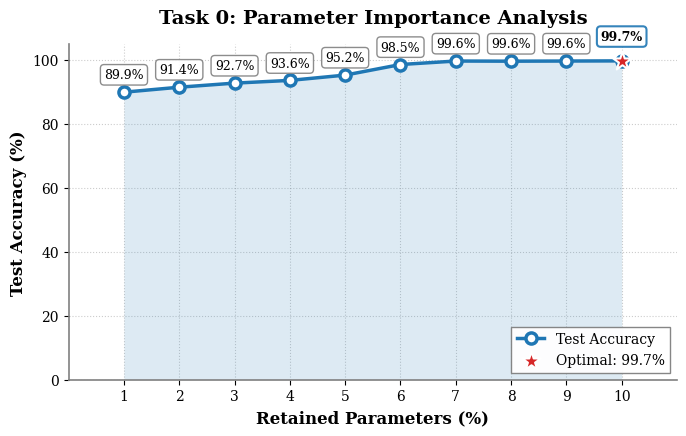


Training on Task 1
Post-training accuracy on Task 1: 99.41%
✓ Figure saved: figures/task_1_importance.pdf


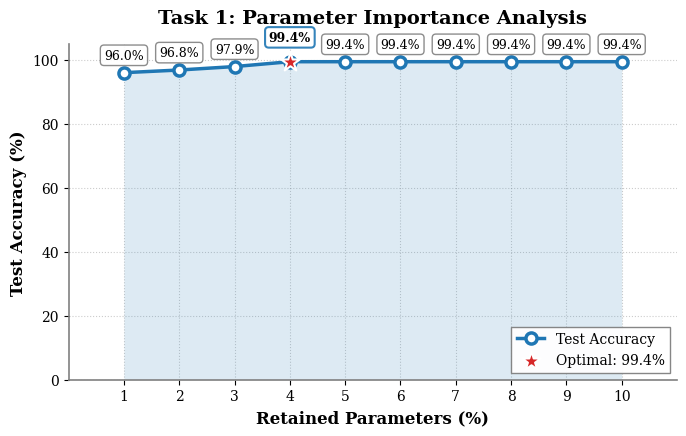


Training on Task 2
Post-training accuracy on Task 2: 99.79%
✓ Figure saved: figures/task_2_importance.pdf


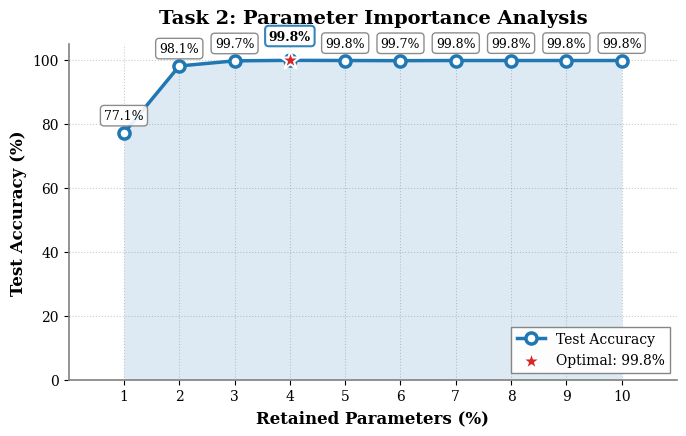


Training on Task 3
Post-training accuracy on Task 3: 99.70%
✓ Figure saved: figures/task_3_importance.pdf


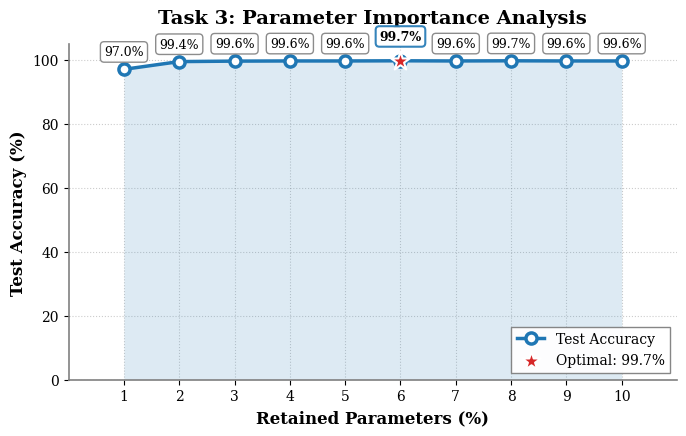


Training on Task 4
Post-training accuracy on Task 4: 98.89%
✓ Figure saved: figures/task_4_importance.pdf


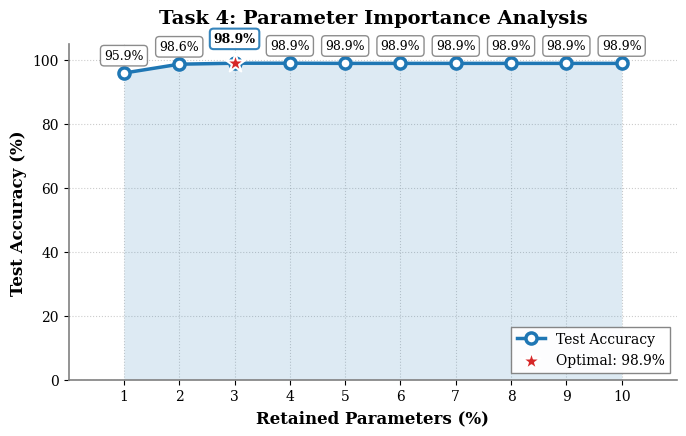

In [ ]:
os.makedirs('figures', exist_ok=True)
all_tasks_data = {}

for task in range(5):
    print(f"\n{'='*70}")
    print(f"Training on Task {task}")
    print(f"{'='*70}")

    naive_train(model, task, epochs, criterion=criterion, optimizer=optimizer, device=device)
    acc = test_taskwise(model, task, device)
    print(f"Post-training accuracy on Task {task}: {acc:.2f}%")

    fisher_dict = compute_fisher_information(model, task_number=task, num_samples=500, 
                                             criterion=criterion, device=device)
    percent_list = list(range(1, 11))
    accuracy_vs_percent = []

    original_weights = {name: param.clone() for name, param in model.state_dict().items()}
    for p in percent_list:
        model, mask_dict = apply_importance_mask(model, fisher_dict, importance_percent=p)
        acc_p = test_taskwise(model, task, device)
        accuracy_vs_percent.append(acc_p)
        model.load_state_dict(original_weights, strict=False)
       
    all_tasks_data[task] = (percent_list, accuracy_vs_percent)
    plot_parameter_importance(
        percent_list=percent_list,
        accuracy_list=accuracy_vs_percent,
        task_id=task,
        save_path=f'figures/task_{task}_importance.pdf',
        show_plot=True  # Set to False to not display during training
    )


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training on Task 0
Post-training accuracy on Task 0: 99.86%
Saving top 10% important weights for Task 0...
Done saving.
✓ Figure saved: figures/task_0_importance.pdf


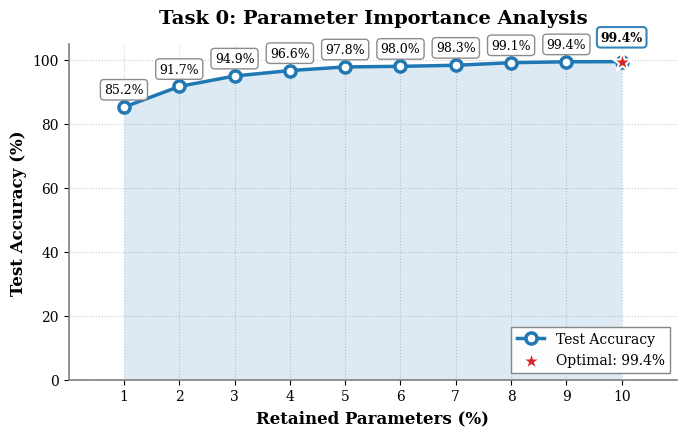


Training on Task 1
Post-training accuracy on Task 1: 99.41%
Saving top 10% important weights for Task 1...
Done saving.
✓ Figure saved: figures/task_1_importance.pdf


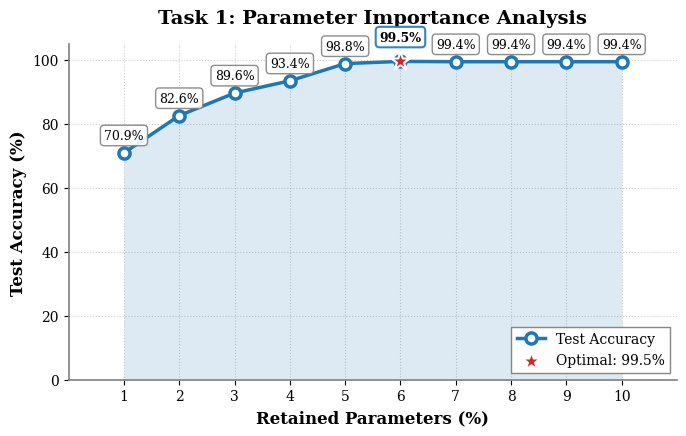


Training on Task 2
Post-training accuracy on Task 2: 99.89%
Saving top 10% important weights for Task 2...
Done saving.
✓ Figure saved: figures/task_2_importance.pdf


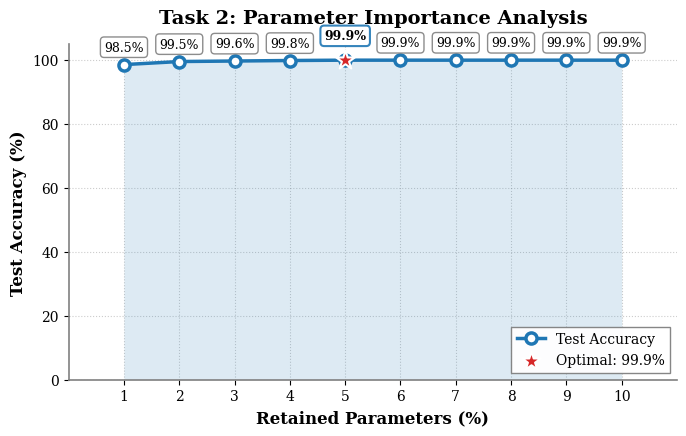


Training on Task 3
Post-training accuracy on Task 3: 99.70%
Saving top 10% important weights for Task 3...
Done saving.
✓ Figure saved: figures/task_3_importance.pdf


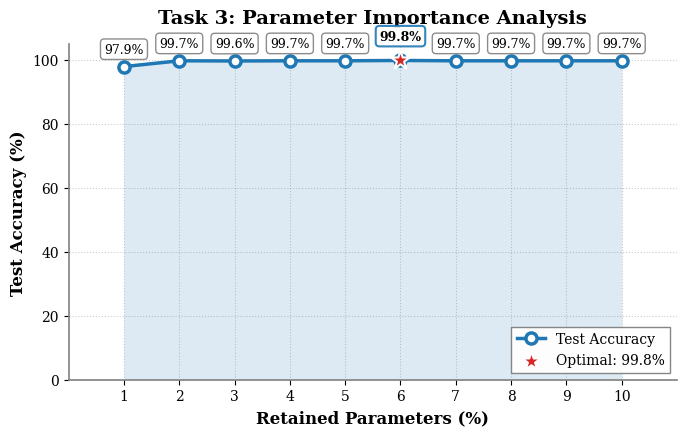


Training on Task 4
Post-training accuracy on Task 4: 99.24%
Saving top 10% important weights for Task 4...
Done saving.
✓ Figure saved: figures/task_4_importance.pdf


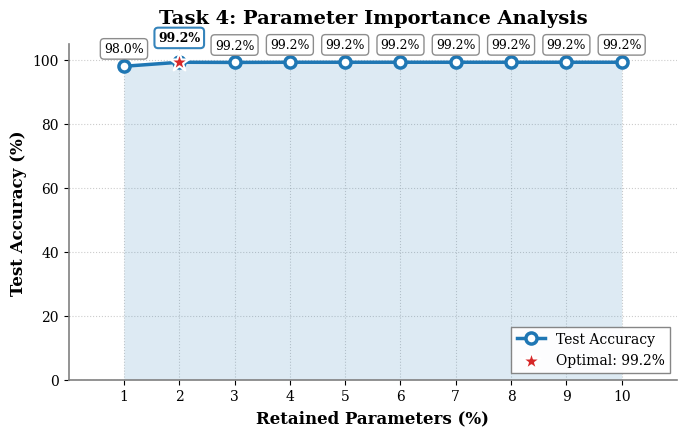


All tasks trained. Final backbone model saved.

Running Final Evaluation...

--- Testing on Task 0 ---
  Method A (Top 10% Only): Accuracy = 99.43%
  Method B (Top 10% + Backbone): Accuracy = 0.00%

--- Testing on Task 1 ---
  Method A (Top 10% Only): Accuracy = 99.41%
  Method B (Top 10% + Backbone): Accuracy = 99.41%

--- Testing on Task 2 ---
  Method A (Top 10% Only): Accuracy = 99.89%
  Method B (Top 10% + Backbone): Accuracy = 99.89%

--- Testing on Task 3 ---
  Method A (Top 10% Only): Accuracy = 99.70%
  Method B (Top 10% + Backbone): Accuracy = 99.70%

--- Testing on Task 4 ---
  Method A (Top 10% Only): Accuracy = 99.24%
  Method B (Top 10% + Backbone): Accuracy = 99.24%

Evaluation complete.


In [ ]:
from model import network_mnist,naive_train,test_taskwise,test,benchmark,train_stream,test_stream,compute_fisher_information,apply_importance_mask
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from plot import plot_parameter_importance
import os
import copy

# -------------------------------------------------------------------
# NEW HELPER FUNCTIONS FOR SAVING/RESTORING WEIGHTS
# -------------------------------------------------------------------

def get_top_n_weights_data(model, fisher_dict, top_n_percent):
    """
    Identifies and returns the top N% of weights based on Fisher scores.
    
    Returns:
        dict: A dictionary containing the mask and values for each layer.
              Format: {name: {'mask': tensor, 'values': tensor}}
    """
    # 1. Flatten all Fisher scores to find the global threshold
    all_scores = torch.cat([f.view(-1) for f in fisher_dict.values()])
    
    # 2. Calculate the threshold value
    threshold_quantile = 1.0 - (top_n_percent / 100.0)
    threshold = torch.quantile(all_scores, threshold_quantile)
    
    important_weights_data = {}
    
    # 3. Create masks and store the original values
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in fisher_dict:
                # Create a binary mask: 1 where score >= threshold, 0 otherwise
                mask = fisher_dict[name] >= threshold
                
                # Use the mask to get the actual weight values
                important_values = param.data[mask]
                
                important_weights_data[name] = {
                    'mask': mask.cpu(),  # Move to CPU for efficiency
                    'values': important_values.cpu()
                }
    return important_weights_data

def restore_weights(model, weights_data):
    """
    Restores the saved important weights into a model in-place.
    
    Args:
        model (nn.Module): The model to restore weights into.
        weights_data (dict): The data from get_top_n_weights_data.
    """
    device = next(model.parameters()).device
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in weights_data:
                data = weights_data[name]
                mask = data['mask'].to(device)
                saved_values = data['values'].to(device)
                
                # Use the mask to "paste" the saved values
                param.data[mask] = saved_values
    return model

# -------------------------------------------------------------------
# SETUP
# -------------------------------------------------------------------

model = network_mnist(256, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

os.makedirs('figures', exist_ok=True)
all_tasks_data = {}
all_task_important_weights = {} # <-- NEW: To store 10% weights

# -------------------------------------------------------------------
# TRAINING LOOP
# -------------------------------------------------------------------

for task in range(5):
    print(f"\n{'='*70}")
    print(f"Training on Task {task}")
    print(f"{'='*70}")

    naive_train(model, task, epochs, criterion=criterion, optimizer=optimizer, device=device)
    acc = test_taskwise(model, task, device)
    print(f"Post-training accuracy on Task {task}: {acc:.2f}%")

    fisher_dict = compute_fisher_information(model, task_number=task, num_samples=500, 
                                             criterion=criterion, device=device)

    # --- NEW: Save the top 10% of weights for this task ---
    print(f"Saving top 10% important weights for Task {task}...")
    task_10_percent_data = get_top_n_weights_data(model, fisher_dict, top_n_percent=10.0)
    all_task_important_weights[task] = task_10_percent_data
    print("Done saving.")
    # --- End of new section ---

    # --- Your original analysis loop (unchanged) ---
    percent_list = list(range(1, 11))
    accuracy_vs_percent = []
    original_weights = {name: param.clone() for name, param in model.state_dict().items()}
    
    for p in percent_list:
        # Note: apply_importance_mask must return a model and mask
        # It is assumed to set non-important weights to 0
        temp_model, mask_dict = apply_importance_mask(model, fisher_dict, importance_percent=p)
        acc_p = test_taskwise(temp_model, task, device)
        accuracy_vs_percent.append(acc_p)
        # Restore original weights to model for the next loop iteration
        model.load_state_dict(original_weights, strict=True) 
       
    all_tasks_data[task] = (percent_list, accuracy_vs_percent)
    plot_parameter_importance(
        percent_list=percent_list,
        accuracy_list=accuracy_vs_percent,
        task_id=task,
        save_path=f'figures/task_{task}_importance.pdf',
        show_plot=True  # Set to False to not display during training
    )
    # --- End of original analysis loop ---

# Save the final model state as the "backbone"
backbone_state_dict = copy.deepcopy(model.state_dict())
print(f"\n{'='*70}")
print("All tasks trained. Final backbone model saved.")
print(f"{'='*70}")

# -------------------------------------------------------------------
# FINAL EVALUATION
# -------------------------------------------------------------------

print("\nRunning Final Evaluation...")

for task_to_test in range(5):
    print(f"\n--- Testing on Task {task_to_test} ---")
    
    # Retrieve the saved 10% weights for this task
    task_data = all_task_important_weights[task_to_test]

    # --- Test A: Top 10% Weights Only (Sparse Model) ---
    sparse_model = network_mnist(256, 128).to(device)
    
    # Initialize all weights to zero
    with torch.no_grad():
        for param in sparse_model.parameters():
            param.data.fill_(0.0)
            
    # Restore only the important 10%
    sparse_model = restore_weights(sparse_model, task_data)
    
    acc_sparse = test_taskwise(sparse_model, task_to_test, device)
    print(f"  Method A (Top 10% Only): Accuracy = {acc_sparse:.2f}%")

    # --- Test B: Top 10% Weights + Backbone ---
    hybrid_model = network_mnist(256, 128).to(device)
    
    # Load the final backbone weights
    hybrid_model.load_state_dict(backbone_state_dict)
    
    # Overwrite with the task-specific 10%
    hybrid_model = restore_weights(hybrid_model, task_data)
    
    acc_hybrid = test_taskwise(hybrid_model, task_to_test, device)
    print(f"  Method B (Top 10% + Backbone): Accuracy = {acc_hybrid:.2f}%")

print("\nEvaluation complete.")